In [1]:
import pandas as pd, numpy as np
from vivarium import Artifact

from pathlib import Path

from math import floor

import matplotlib.pyplot as plt

import pdb

from datetime import datetime

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
FORECASTED_POP_KEY = "population.structure"
SCALING_FACTOR_KEY = "population.scaling_factor"
ACMR_KEY = "cause.all_causes.cause_specific_mortality_rate"
CSMR_KEY = "cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate"
BBBM_INCIDENCE_KEY = "cause.alzheimers.susceptible_to_bbbm_transition_count"
TIME_STEP_YEARS = 1
GBD_AGE_GROUP_YEARS = 5
TIME_STEPS_PER_AGE_GROUP = GBD_AGE_GROUP_YEARS / TIME_STEP_YEARS

SIM_START = 2025
SIM_END = 2101

_location = "United States of America"
ARTIFACTS_DIR = (
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0"
)

BBBM_TESTING_RATES = [
    (2027, 0.02),
    (2030, 0.1),
    # (2035, 0.2),
    # (2040, 0.3),
    (2045, 0.5),
    (2055, 0.6),
    (SIM_END, 0.6),
]

VARIABLE_TREATMENT_INITIATION_RATES = [
    (2035, 0.3),
    # (2035, 0.7),
    (SIM_END, 0.8),
]

# US_TREATMENT_INITIATION_RATES = [
#     (2030, 0.3),
#     (SIM_END, 0.3),
# ]

# JAPAN_TREATMENT_INITIATION_RATES = [
#     (2030, 0.8),
#     (SIM_END, 0.8),
# ]

TREATMENT_INITIATION_RATES_LOOKUP = {
    "United States of America": VARIABLE_TREATMENT_INITIATION_RATES,
    "Japan": VARIABLE_TREATMENT_INITIATION_RATES,
}

NON_AGE_OBSERVERS = [
    "deaths",
    "exits_to_sim",
    "incidence",
    "age_outs",
    "to_test",
    "new_tests",
    "new_pos_tests",
    "incident_tests",
    "over_thresh",
    "neg_0ya",
    "neg_1ya",
    "neg_2ya",
    "neg_3ya",
    "neg_4ya",
    "pos",
    "treatment_initiated",
    "treatment_not_initiated",
    "treatment_completed",
    "treatment_discontinued",
]

LOCATIONS = [
    "United States of America",
    # "Sweden",
    "China",
    # "Japan",
    # "Brazil",
    # "United Kingdom",
    # "Germany",
    # "Spain",
    # "Israel",
    # "Taiwan (Province of China)",
]

DRAWS = [
    457,
    169,
    # 323,
    # 392,
    # 346,
    # 480,
    # 258,
    # 446,
    # 356,
    # 273,
    # 158,
    # 24,
    # 265,
    # 317,
    # 177,
    # 199,
    # 2,
    # 13,
    # 46,
    # 89,
    # 41,
    # 113,
    # 262,
    # 460,
    # 499,
]

In [3]:
def get_bbbm_testing_rate(year):
    years = [year for year, _ in BBBM_TESTING_RATES]
    rates = [rate for _, rate in BBBM_TESTING_RATES]
    if year < years[0]:
        # 0.0 before first year with defined rate
        return 0.0
    elif year > years[-1]:
        return years[-1]
    else:
        return np.interp(year, years, rates)

In [4]:
def get_treatment_inititaion_rate(location, year):
    LOC_SPECIFIC_RATES = TREATMENT_INITIATION_RATES_LOOKUP.get(
        location, VARIABLE_TREATMENT_INITIATION_RATES
    )
    years = [year for year, _ in LOC_SPECIFIC_RATES]
    rates = [rate for _, rate in LOC_SPECIFIC_RATES]
    if year < years[0]:
        return 0.0
    elif year > years[-1]:
        return 0.0
    else:
        return np.interp(year, years, rates)

In [5]:
def load_artifact(location):
    art_filename = f"{location.lower().replace(' ', '_')}.hdf"
    return Artifact(Path(ARTIFACTS_DIR) / art_filename)

In [6]:
def initialize_pop_table(location, draw) -> pd.DataFrame:
    art = load_artifact(location)
    forecasted_pop = (
        art.load(FORECASTED_POP_KEY)
        .query("year_start == 2021 & age_start >=60 & age_start<80")[f"draw_{draw}"]
        .droplevel(["location", "year_start", "year_end"])
    )
    all_states_prev = (
        art.load(SCALING_FACTOR_KEY)
        .query("age_start >=60 & age_start<80")[f"draw_{draw}"]  # only 2023 data
        .droplevel(["year_start", "year_end"])
    )
    groups = forecasted_pop * (1 - all_states_prev)
    # build table with rows where age_end - age_start = time step (1 year)
    table = pd.DataFrame(
        index=pd.MultiIndex.from_tuples([], names=list(groups.index.names)),
        columns=["over_thresh", "neg_0ya", "neg_1ya", "neg_2ya", "neg_3ya", "neg_4ya", "pos", "to_test"],
    )
    for index, value in groups.items():
        (sex, age_start, age_end) = index
        while age_start < age_end:
            table.loc[(sex, age_start, age_start + 1)] = {
                "over_thresh": value / TIME_STEPS_PER_AGE_GROUP,
                # 0% annual testing rate at sim start
                "neg_0ya": 0,
                "neg_1ya": 0,
                "neg_2ya": 0,
                "neg_3ya": 0,
                "neg_4ya": 0,
                "pos": 0,
                "to_test": 0,  # placeholder for on time step calculations - this should always be 0 once the table is updated
            }

            age_start += 1
    for sex in ['Female', 'Male']:
        table.loc[sex, 'over_thresh'] = table.loc[sex, 'over_thresh'].rolling(
        window=5, center=True, min_periods=1).mean().values
    return table

## Abie thinks smoothing over thresh might make the ripples decrease or go away entirely 

In [7]:
def get_prev_table_index(cur_index):
    (sex, age_start, age_end) = cur_index
    return (sex, age_start - TIME_STEP_YEARS, age_end - TIME_STEP_YEARS)

In [8]:
def increase_person_time_keys(person_time, keys: dict):
    for key, amount in keys.items():
        person_time[key] += amount


def move_people(row, from_col: str, to_col: str, count):
    row[from_col] -= count
    row[to_col] += count


def run_time_step(
    pop_table, location, year, draw, new_entrants, bbbm_incidence, mortality
):
    all_person_times = []
    for index, row in pop_table.iloc[::-1].iterrows():  # iterate ages in reverse order
        (sex, age_start, _) = index

        # initialize observer
        person_time = {
            "location": location,
            "year": year,
            "sex": sex,
            "age_start": age_start,
            "input_draw": draw,
        }

        for observer_key in NON_AGE_OBSERVERS:
            person_time[observer_key] = 0
            person_time[observer_key] = 0

        # calculate indexes and rates
        prev_index = get_prev_table_index(index)
        lookup_year = min(year, 2050)

        test_rate = get_bbbm_testing_rate(year)

        # 60 YEAR OLDS
        if age_start == 60:
            row[:] = 0  # clear previous years populatoin
            total_incident_60_yos = (
                new_entrants.loc[(sex, lookup_year)] / GBD_AGE_GROUP_YEARS
            )

            # test X% of new 60 yos (will move to "neg 0 y ago" or "positive")
            row.to_test = total_incident_60_yos * test_rate
            # other new 60 yos do not meet propensity threshold
            row.over_thresh = total_incident_60_yos * (1 - test_rate)

            increase_person_time_keys(
                person_time,
                {
                    "incidence": total_incident_60_yos,
                    "incident_tests": total_incident_60_yos * test_rate,
                },
            )
        # OTHER AGES
        else:
            if age_start == 79:  # record people aging out of table
                increase_person_time_keys(
                    person_time, {"age_outs": sum(pop_table.loc[index])}
                )

            # move people into new age groups:
            row = pop_table.loc[prev_index]  # previous age group

            # MORTALITY
            age_group_start = (
                floor((age_start - 1) / GBD_AGE_GROUP_YEARS) * GBD_AGE_GROUP_YEARS
            )  # previous age_start, rounded to GBD age group boundaries

            index_in_groups = (
                sex,
                age_group_start,
                age_group_start + 5,
                lookup_year,
                lookup_year + 1,
            )
            mortality_rate = mortality.loc[index_in_groups]
            increase_person_time_keys(
                person_time, {"deaths": row.over_thresh * mortality_rate}
            )
            row.over_thresh *= 1 - mortality_rate

            # REMOVE THOSE ENTERING SIM (incident to pre-clinical):
            exits_to_sim = bbbm_incidence.loc[index_in_groups] / GBD_AGE_GROUP_YEARS
            row.over_thresh -= exits_to_sim
            increase_person_time_keys(person_time, {"exits_to_sim": exits_to_sim})

            # UPDATE STATES
            delta = test_rate - get_bbbm_testing_rate(year - 1)
            prob_2_to_test = 0.333
            prob_3_to_test = 0.5
            total_age_pop = sum(row)
            # Note: The total age pop denominator we use is important, as well as whether it
            #       includes people who have tested positive.
            # For now, I'm keeping people who test positive in the sim so that they are included
            # in this denominator with the goal of matching "% ever eligible tested" metric
            move_people(row, "over_thresh", "to_test", delta * total_age_pop)

            move_people(row, "neg_4ya", "to_test", row.neg_4ya)
            assert row.neg_4ya == 0 

            move_people(row, "neg_3ya", "to_test", row.neg_3ya * prob_3_to_test)
            move_people(row, "neg_3ya", "neg_4ya", row.neg_3ya)
            assert row.neg_3ya == 0 

            move_people(row, "neg_2ya", "to_test", row.neg_2ya * prob_2_to_test)
            move_people(row, "neg_2ya", "neg_3ya", row.neg_2ya)
            assert row.neg_2ya == 0 

            move_people(row, "neg_1ya", "neg_2ya", row.neg_1ya)
            move_people(row, "neg_0ya", "neg_1ya", row.neg_0ya)

        # if index[0] == "Female" and ((age_start - 60) % 3 == 0):
        #    print(f"{year}, {age_start}: {row.to_test} / {row.sum()}")

        # record number of tests and positive tests
        pos_tests = row.to_test * 0.025  # 2.5% of tests are false positive
        increase_person_time_keys(person_time, {"new_tests": row.to_test})
        increase_person_time_keys(person_time, {"new_pos_tests": pos_tests})

        # TEST
        move_people(row, "to_test", "pos", pos_tests)
        # remainder are true negative
        move_people(row, "to_test", "neg_0ya", row.to_test)
        # now to_test should be back to zero

        # TREATMENT
        treatment_initiation_rate = get_treatment_inititaion_rate(location, year)
        initiations = pos_tests * treatment_initiation_rate
        non_initiations = pos_tests * (1 - treatment_initiation_rate)
        treatment_completions = initiations * 0.9
        treatment_discontinuations = initiations * 0.1

        # UPDATE COLUMN AND TREATMENT OBSERVERS
        increase_person_time_keys(
            person_time,
            {
                "over_thresh": row.over_thresh,
                "neg_0ya": row.neg_0ya,
                "neg_1ya": row.neg_1ya,
                "neg_2ya": row.neg_2ya,
                "neg_3ya": row.neg_3ya,
                "neg_4ya": row.neg_4ya,
                "pos": row.pos,
                "treatment_initiated": initiations,
                "treatment_not_initiated": non_initiations,
                "treatment_completed": treatment_completions,
                "treatment_discontinued": treatment_discontinuations,
            },
        )

        # person_times[sex][age_start] = person_times[sex].get(age_start, 0) + row.sum()
        all_person_times.append(person_time)
        pop_table.loc[index] = row

    return all_person_times

In [9]:
def load_background_mortality(location, draw):
    # copied from loader.py
    art = load_artifact(location)
    acmr = art.load(ACMR_KEY)
    csmr = art.load(CSMR_KEY).droplevel(["year_start", "year_end"])

    # for now, assume csmr is the same for all years based on docs
    csmr_all_years = pd.DataFrame(csmr, index=acmr.index)
    return (acmr - csmr_all_years).query("age_start >= 60 & age_start < 80")[
        f"draw_{draw}"
    ]

In [10]:
def load_inc_mort(location, draw):
    # calculate 60 to 61 year olds who are not in simulation for each forecast year
    art = load_artifact(location)
    new_entrants_forecasted = (
        art.load(FORECASTED_POP_KEY)
        .query("age_start == 60")[f"draw_{draw}"]
        .droplevel(["location", "age_start", "age_end", "year_end"])
    )
    new_entrants_all_states_prev = (
        art.load(SCALING_FACTOR_KEY)
        .query("age_start == 60")[f"draw_{draw}"]  # only 2023 data
        .droplevel(["age_start", "age_end", "year_start", "year_end"])
    )
    new_entrants = new_entrants_forecasted * (1 - new_entrants_all_states_prev)

    background_mortality = load_background_mortality(location, draw)
    # starts in 2022, manually copy 2022 data to 2021
    for index, value in background_mortality.items():
        (sex, age_start, age_end, year_start, year_end) = index
        if year_start == 2022:
            background_mortality.loc[(sex, age_start, age_end, 2021, 2022)] = value

    background_mortality.loc[("Male", 60, 65, 2021, 2022)] = background_mortality.loc[
        ("Male", 60, 65, 2022, 2023)
    ]

    bbbm_incidence_counts = art.load(BBBM_INCIDENCE_KEY).query(
        "age_start >= 60 & age_start < 80"
    )[f"draw_{draw}"]
    return (new_entrants, bbbm_incidence_counts, background_mortality)

In [11]:
# person-time observer
person_time = []

for draw in DRAWS:

    for location in LOCATIONS:
        # population table of people in location ages 60-80 who do not have pre-clinical, MCI or AD
        pop_table = initialize_pop_table(location, draw)
        (new_entrants, bbbm_incidence_counts, background_mortality) = load_inc_mort(
            location, draw
        )

        for year in range(SIM_START, SIM_END):
            step_person_times = run_time_step(
                pop_table,
                location,
                year,
                draw,
                new_entrants,
                bbbm_incidence_counts,
                background_mortality,
            )
            person_time += step_person_times

In [12]:
# calculations csv output

VERSION = 3
# v2 = original submitted results
# v3 = 99.8% specificity
datestr = datetime.now().strftime("%Y_%m_%d")
pt_output = pd.DataFrame(person_time)
pt_output_final = pt_output[
    [
        "location",
        "year",
        "sex",
        "age_start",
        "input_draw",
        "new_tests",
        "new_pos_tests",
        "treatment_initiated",
    ]
]

age_start = (5 * np.floor(pt_output_final["age_start"] / 5)).astype(int)
pt_output_final["age_group"] = (
    age_start.astype(str) + "_to_" + (age_start + 4).astype(str)
)

pt_output_final["input_draw"] = "draw_" + pt_output_final["input_draw"].astype(str)

pt_output_final = pt_output_final.drop(
    "age_start",
    axis=1,
).rename(
    columns={
        "new_tests": "bbbm_test_count",
        "new_pos_tests": "bbbm_positive_test_count",
        "treatment_initiated": "treatment_initiation_count",
    }
)
pt_output_final = (
    pt_output_final[
        [
            "location",
            "year",
            "sex",
            "age_group",
            "input_draw",
            "bbbm_test_count",
            "bbbm_positive_test_count",
            "treatment_initiation_count",
        ]
    ]
    .groupby(["location", "year", "sex", "age_group", "input_draw"])
    .sum()
)
pt_output_final

bbbm_test_count  \
location                 year sex    age_group input_draw                    
China                    2025 Female 60_to_64  draw_169       0.000000e+00   
                                               draw_457       0.000000e+00   
                                     65_to_69  draw_169       0.000000e+00   
                                               draw_457       0.000000e+00   
                                     70_to_74  draw_169       0.000000e+00   
...                                                                    ...   
United States of America 2100 Male   65_to_69  draw_457       1.473509e+06   
                                     70_to_74  draw_169       1.425278e+06   
                                               draw_457       1.383844e+06   
                                     75_to_79  draw_169       1.405974e+06   
                                               draw_457       1.365101e+06   

                                                           bbbm_positive_test_count  \
location                 year sex    age_group input_draw                             
China                    2025 Female 60_to_64  draw_169                    0.000000   
                                               draw_457                    0.000000   
                                     65_to_69  draw_169                    0.000000   
                                               draw_457                    0.000000   
                                     70_to_74  draw_169                    0.000000   
...                                                                             ...   
United States of America 2100 Male   65_to_69  draw_457                36837.725281   
                                     70_to_74  draw_169                35631.960981   
                                               draw_457                34596.109132   
                                     75_to_79  draw_169                35149.343091   
                                               draw_457                34127.521360   

                                                           treatment_initiation_count  
location                 year sex    age_group input_draw                              
China                    2025 Female 60_to_64  draw_169                      0.000000  
                                               draw_457                      0.000000  
                                     65_to_69  draw_169                      0.000000  
                                               draw_457                      0.000000  
                                     70_to_74  draw_169                      0.000000  
...                                                                               ...  
United States of America 2100 Male   65_to_69  draw_457                  29191.106549  
                                     70_to_74  draw_169                  28235.629686  
                                               draw_457                  27414.795570  
                                     75_to_79  draw_169                  27853.191570  
                                               draw_457                  27043.475260  

[2432 rows x 3 columns]

In [13]:
# v&v final output
pt_output_final.loc["United States of America"].groupby(
    ["year", "sex", "age_group"]
).mean().sum()

bbbm_test_count               8.098992e+08
bbbm_positive_test_count      2.024748e+07
treatment_initiation_count    1.112488e+07
dtype: float64

Previous results:

'Total BBBM tests conducted from 2021 to 2100: 837611619.3024542'

'Total false positive BBBM tests from 2021 to 2100: 83761161.93024546'

'Total uncessecary treatments initiated from 2021 to 2100: 67008929.544196375'

In [31]:
LOCATIONS

['United States of America', 'China']

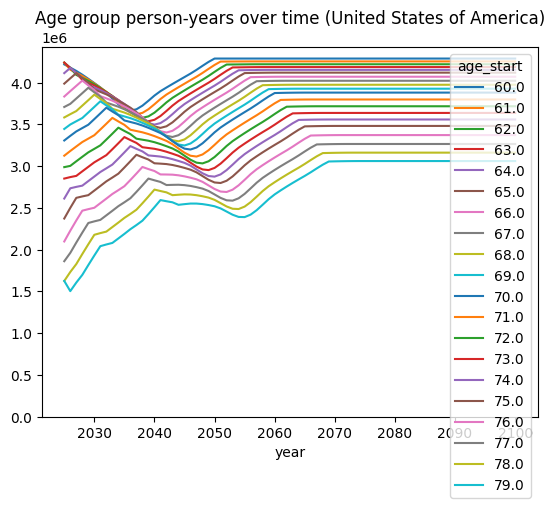

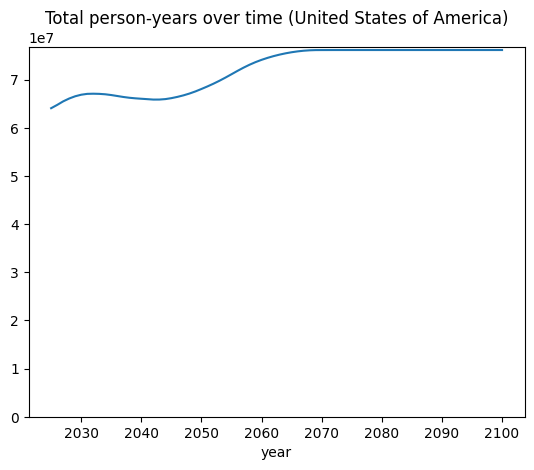

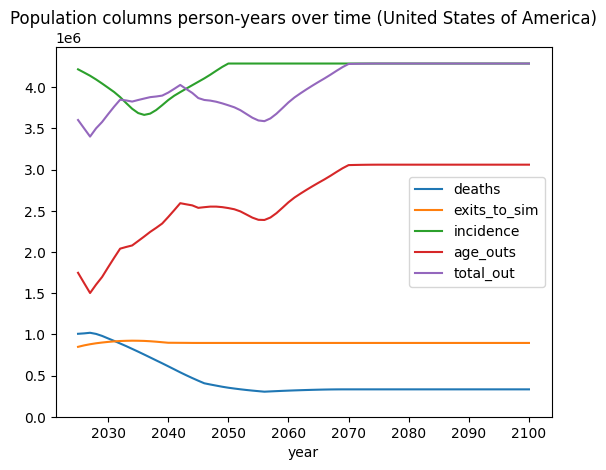

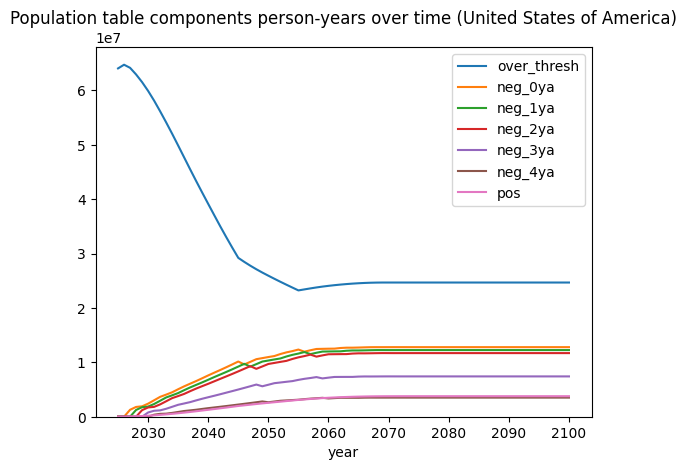

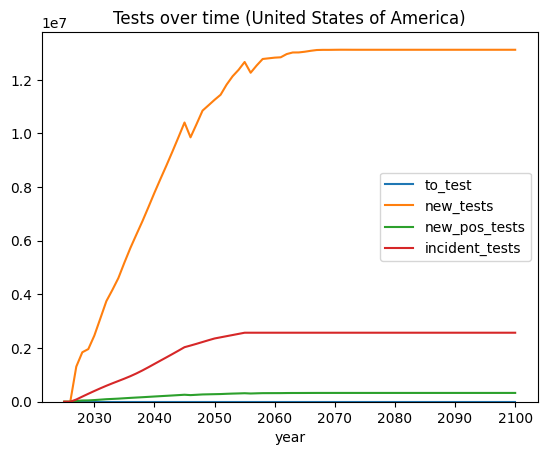

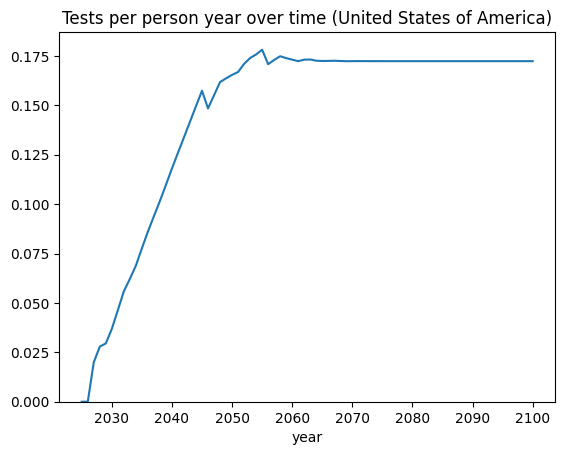

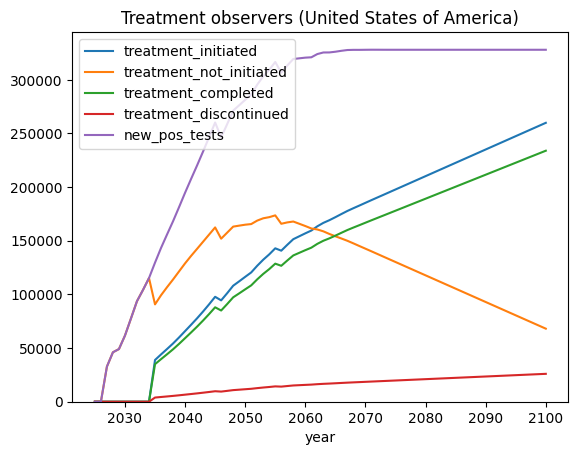

In [14]:
def show_plot(title: str, location: str):
    plt.ylim(bottom=0)
    plt.title(f"{title} ({location})")
    plt.show()


plot_loc = LOCATIONS[0]
pt = pt_output[pt_output["location"] == plot_loc]

pop_cols = ["over_thresh", "neg_0ya", "neg_1ya", "neg_2ya", "neg_3ya", "neg_4ya", "pos"]
pt["total_pop"] = pt[pop_cols].sum(axis=1)
pt["total_out"] = pt[["deaths", "exits_to_sim", "age_outs"]].sum(axis=1)

pt = pt.groupby(["location", "year", "sex", "age_start"]).mean()

pt.groupby(["year", "age_start"]).sum()["total_pop"].unstack().plot()
show_plot("Age group person-years over time", plot_loc)

pt.groupby(["year"]).sum()["total_pop"].plot()
show_plot("Total person-years over time", plot_loc)

pt.groupby(["year"]).sum()[
    ["deaths", "exits_to_sim", "incidence", "age_outs", "total_out"]
].plot()
show_plot("Population columns person-years over time", plot_loc)

pt.groupby(["year"]).sum()[pop_cols].plot()
show_plot("Population table components person-years over time", plot_loc)

pt.groupby(["year"]).sum()[
    ["to_test", "new_tests", "new_pos_tests", "incident_tests"]
].plot()
show_plot("Tests over time", plot_loc)

tmp = pt.groupby(["year"]).sum()
(tmp["new_tests"] / tmp["total_pop"]).plot()
show_plot("Tests per person year over time", plot_loc)

pt.groupby(["year"]).sum()[
    [
        "treatment_initiated",
        "treatment_not_initiated",
        "treatment_completed",
        "treatment_discontinued",
        "new_pos_tests",
    ]
].plot()
show_plot("Treatment observers", plot_loc)

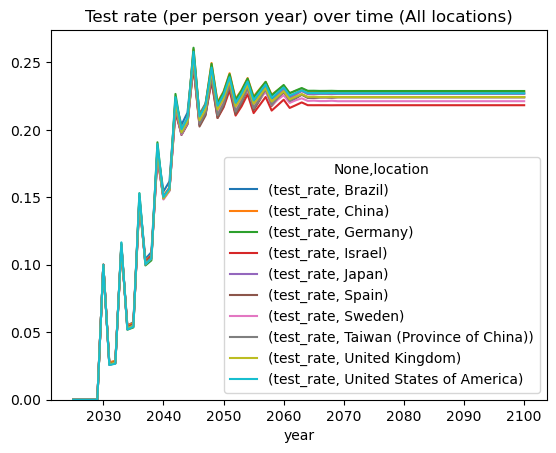

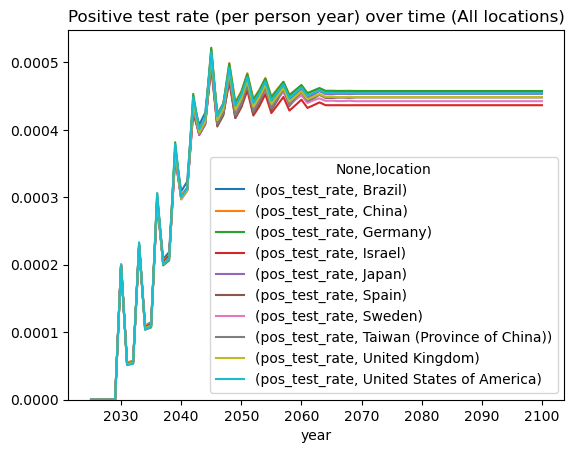

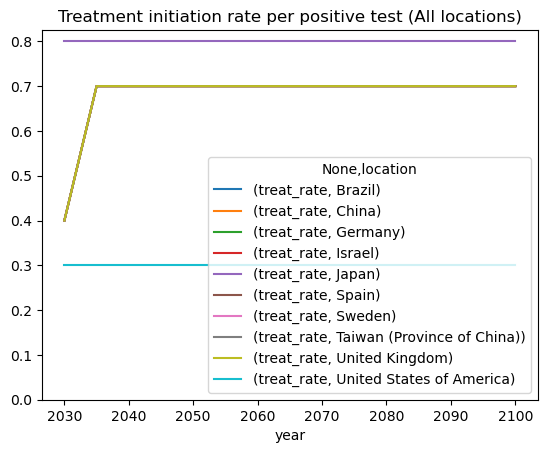

In [23]:
test_rates = pt_output
test_rates["total_pop"] = test_rates[pop_cols].sum(axis=1)
test_rates = test_rates.groupby(["year", "location"]).sum()[
    ["new_tests", "new_pos_tests", "treatment_initiated", "total_pop"]
]
test_rates["test_rate"] = test_rates["new_tests"] / test_rates["total_pop"]
test_rates["pos_test_rate"] = test_rates["new_pos_tests"] / test_rates["total_pop"]
test_rates["treat_rate"] = (
    test_rates["treatment_initiated"] / test_rates["new_pos_tests"]
)

test_rates[["test_rate"]].unstack().plot()
show_plot("Test rate (per person year) over time", "All locations")

test_rates[["pos_test_rate"]].unstack().plot()
show_plot("Positive test rate (per person year) over time", "All locations")

test_rates[["treat_rate"]].unstack().plot()
show_plot("Treatment initiation rate per positive test", "All locations")

In [24]:
pt_output_final

bbbm_test_count  \
location                 year sex    age_group input_draw                    
Brazil                   2025 Female 60_to_64  draw_113       0.000000e+00   
                                               draw_13        0.000000e+00   
                                               draw_158       0.000000e+00   
                                               draw_169       0.000000e+00   
                                               draw_177       0.000000e+00   
...                                                                    ...   
United States of America 2100 Male   75_to_79  draw_46        2.415552e+06   
                                               draw_460       2.450264e+06   
                                               draw_480       2.303537e+06   
                                               draw_499       2.375794e+06   
                                               draw_89        2.539286e+06   

                                                           bbbm_positive_test_count  \
location                 year sex    age_group input_draw                             
Brazil                   2025 Female 60_to_64  draw_113                    0.000000   
                                               draw_13                     0.000000   
                                               draw_158                    0.000000   
                                               draw_169                    0.000000   
                                               draw_177                    0.000000   
...                                                                             ...   
United States of America 2100 Male   75_to_79  draw_46                  4831.103922   
                                               draw_460                 4900.528475   
                                               draw_480                 4607.073185   
                                               draw_499                 4751.588743   
                                               draw_89                  5078.572011   

                                                           treatment_initiation_count  
location                 year sex    age_group input_draw                              
Brazil                   2025 Female 60_to_64  draw_113                      0.000000  
                                               draw_13                       0.000000  
                                               draw_158                      0.000000  
                                               draw_169                      0.000000  
                                               draw_177                      0.000000  
...                                                                               ...  
United States of America 2100 Male   75_to_79  draw_46                    1449.331177  
                                               draw_460                   1470.158543  
                                               draw_480                   1382.121956  
                                               draw_499                   1425.476623  
                                               draw_89                    1523.571603  

[152000 rows x 3 columns]

In [25]:
def describe_col(col):
    col = col.groupby(["location", "year", "sex", "age_group"]).describe(
        percentiles=[0.025, 0.975]
    )
    return col[["mean", "2.5%", "97.5%"]].reset_index()


def add_cols_and_rename(
    df, measure: str, include_uncertainty=True, scen="BBBM Testing and Treatment"
):
    df["Disease Stage"] = "Susceptible"
    df["Scenario"] = scen
    df["Measure"] = measure
    df["Metric"] = "Number"

    cols_rename = {
        "location": "Location",
        "year": "Year",
        "sex": "Sex",
        "age_group": "Age",
        "mean": "Mean",
        "input_draw": "Draw",
    }
    if include_uncertainty:
        cols_rename["2.5%"] = "95% UI Lower"
        cols_rename["97.5%"] = "95% UI Upper"
    df = df.reset_index().rename(columns=cols_rename)

    cols_return = [
        "Year",
        "Location",
        "Age",
        "Sex",
        "Disease Stage",
        "Scenario",
        "Measure",
        "Metric",
        "Draw",
        "Value",
    ]
    if include_uncertainty:
        cols_return = pd.concat(cols_return, ["95% UI Lower", "95% UI Upper"])
    return df.reset_index()[cols_return]


def concat_all_measures(df, scenario, include_uncertainty):
    susc_tests = add_cols_and_rename(
        pd.DataFrame(pt_output_final["bbbm_test_count"]).rename(
            columns={"bbbm_test_count": "Value"}
        ),
        "BBBM Tests",
        include_uncertainty,
        scenario,
    )

    fp_tests = add_cols_and_rename(
        pd.DataFrame(pt_output_final["bbbm_positive_test_count"]).rename(
            columns={"bbbm_positive_test_count": "Value"}
        ),
        "BBBM False Positive Tests",
        include_uncertainty,
        scenario,
    )

    susc_treat = add_cols_and_rename(
        pd.DataFrame(pt_output_final["treatment_initiation_count"]).rename(
            columns={"treatment_initiation_count": "Value"}
        ),
        "Improper Medication Uses",
        include_uncertainty,
        scenario,
    )
    return pd.concat([susc_tests, fp_tests, susc_treat])

# Full draws, all measures, copy for both scenarios csv

In [26]:
df = pt_output_final
pt_output_final_test_only = concat_all_measures(df, "BBBM Testing Only", False)
pt_output_final_test_treat = concat_all_measures(
    df, "BBBM Testing and Treatment", False
)
pt_output_final_csv = pd.concat([pt_output_final_test_only, pt_output_final_test_treat])
pt_output_final_csv

,Year,Location,Age,Sex,Disease Stage,Scenario,Measure,Metric,Draw,Value
0,2025,Brazil,60_to_64,Female,Susceptible,BBBM Testing Only,BBBM Tests,Number,draw_113,0.000000
1,2025,Brazil,60_to_64,Female,Susceptible,BBBM Testing Only,BBBM Tests,Number,draw_13,0.000000
2,2025,Brazil,60_to_64,Female,Susceptible,BBBM Testing Only,BBBM Tests,Number,draw_158,0.000000
3,2025,Brazil,60_to_64,Female,Susceptible,BBBM Testing Only,BBBM Tests,Number,draw_169,0.000000
4,2025,Brazil,60_to_64,Female,Susceptible,BBBM Testing Only,BBBM Tests,Number,draw_177,0.000000
...,...,...,...,...,...,...,...,...,...,...
151995,2100,United States of America,75_to_79,Male,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,draw_46,1449.331177
151996,2100,United States of America,75_to_79,Male,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,draw_460,1470.158543
151997,2100,United States of America,75_to_79,Male,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,draw_480,1382.121956
151998,2100,United States of America,75_to_79,Male,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,draw_499,1425.476623


In [27]:
# full draw level data

pt_output_final_csv.to_csv(f"v{VERSION}_{datestr}_outside_sim_results_draw_level.csv")

# Measure-specific csvs

Final client csv format - susceptible BBBM tests:

In [ ]:
susc_tests = describe_col(pt_output_final["bbbm_test_count"])
susc_tests

,location,year,sex,age_group,mean
0,Brazil,2025,Female,60_to_64,0.000000e+00
1,Brazil,2025,Female,65_to_69,0.000000e+00
2,Brazil,2025,Female,70_to_74,0.000000e+00
3,Brazil,2025,Female,75_to_79,0.000000e+00
4,Brazil,2025,Male,60_to_64,0.000000e+00
...,...,...,...,...,...
6075,United States of America,2100,Female,75_to_79,1.467749e+06
6076,United States of America,2100,Male,60_to_64,2.317253e+06
6077,United States of America,2100,Male,65_to_69,1.876975e+06
6078,United States of America,2100,Male,70_to_74,8.001842e+05


In [177]:
susc_tests = add_cols_and_rename(susc_tests, "BBBM Tests")
susc_tests

,Year,Location,Age,Sex,Disease Stage,Scenario,Measure,Metric,Mean,95% UI Lower,95% UI Upper
0,2025,Brazil,60_to_65,Female,Susceptible,BBBM Testing and Treatment,BBBM Tests,Number,0.000000e+00,0.000000e+00,0.000000e+00
1,2025,Brazil,65_to_70,Female,Susceptible,BBBM Testing and Treatment,BBBM Tests,Number,0.000000e+00,0.000000e+00,0.000000e+00
2,2025,Brazil,70_to_75,Female,Susceptible,BBBM Testing and Treatment,BBBM Tests,Number,0.000000e+00,0.000000e+00,0.000000e+00
3,2025,Brazil,75_to_80,Female,Susceptible,BBBM Testing and Treatment,BBBM Tests,Number,0.000000e+00,0.000000e+00,0.000000e+00
4,2025,Brazil,60_to_65,Male,Susceptible,BBBM Testing and Treatment,BBBM Tests,Number,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
6075,2100,United States of America,75_to_80,Female,Susceptible,BBBM Testing and Treatment,BBBM Tests,Number,1.467749e+06,1.362363e+06,1.549757e+06
6076,2100,United States of America,60_to_65,Male,Susceptible,BBBM Testing and Treatment,BBBM Tests,Number,2.317253e+06,2.153712e+06,2.449146e+06
6077,2100,United States of America,65_to_70,Male,Susceptible,BBBM Testing and Treatment,BBBM Tests,Number,1.876975e+06,1.744506e+06,1.983808e+06
6078,2100,United States of America,70_to_75,Male,Susceptible,BBBM Testing and Treatment,BBBM Tests,Number,8.001842e+05,7.437106e+05,8.457287e+05


In [178]:
datestr = datetime.now().strftime("%Y_%m_%d")
susc_tests.to_csv(f"{datestr}_susceptible_bbbm_tests_final.csv")

Final client csv format - BBBM false positive tests:

In [179]:
fp_tests = describe_col(pt_output_final["bbbm_positive_test_count"])

In [ ]:
fp_tests = add_cols_and_rename(fp_tests, "BBBM False Positive Tests")
fp_tests

,Year,Location,Age,Sex,Disease Stage,Scenario,Measure,Metric,Mean,95% UI Lower,95% UI Upper
0,2025,Brazil,60_to_65,Female,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,0.000000,0.000000,0.000000
1,2025,Brazil,65_to_70,Female,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,0.000000,0.000000,0.000000
2,2025,Brazil,70_to_75,Female,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,0.000000,0.000000,0.000000
3,2025,Brazil,75_to_80,Female,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,0.000000,0.000000,0.000000
4,2025,Brazil,60_to_65,Male,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
6075,2100,United States of America,75_to_80,Female,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,146774.863478,136236.289374,154975.735010
6076,2100,United States of America,60_to_65,Male,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,231725.331175,215371.159718,244914.562719
6077,2100,United States of America,65_to_70,Male,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,187697.518252,174450.639371,198380.795803
6078,2100,United States of America,70_to_75,Male,Susceptible,BBBM Testing and Treatment,BBBM False Positive Tests,Number,80018.415676,74371.062048,84572.865579


In [181]:
datestr = datetime.now().strftime("%Y_%m_%d")
fp_tests.to_csv(f"{datestr}_false_positive_bbbm_tests_final.csv")

Final client csv format - Improper medication uses (susceptible treatment initiations):

In [182]:
susc_treat = describe_col(pt_output_final["treatment_initiation_count"])

In [ ]:
susc_treat = describe_col(pt_output_final["treatment_initiation_count"])
susc_treat = add_cols_and_rename(susc_treat, "Improper Medication Uses")
susc_treat

,Year,Location,Age,Sex,Disease Stage,Scenario,Measure,Metric,Mean,95% UI Lower,95% UI Upper
0,2025,Brazil,60_to_65,Female,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,0.000000,0.000000,0.000000
1,2025,Brazil,65_to_70,Female,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,0.000000,0.000000,0.000000
2,2025,Brazil,70_to_75,Female,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,0.000000,0.000000,0.000000
3,2025,Brazil,75_to_80,Female,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,0.000000,0.000000,0.000000
4,2025,Brazil,60_to_65,Male,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
6075,2100,United States of America,75_to_80,Female,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,44032.459043,40870.886812,46492.720503
6076,2100,United States of America,60_to_65,Male,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,69517.599352,64611.347915,73474.368816
6077,2100,United States of America,65_to_70,Male,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,56309.255475,52335.191811,59514.238741
6078,2100,United States of America,70_to_75,Male,Susceptible,BBBM Testing and Treatment,Improper Medication Uses,Number,24005.524703,22311.318614,25371.859674


In [184]:
datestr = datetime.now().strftime("%Y_%m_%d")
susc_treat.to_csv(f"{datestr}_improper_medication_uses_final.csv")

In [185]:
display(susc_tests[susc_tests["Location"] == "United States of America"]["Mean"].sum())
display(fp_tests[fp_tests["Location"] == "United States of America"]["Mean"].sum())
display(susc_treat[susc_treat["Location"] == "United States of America"]["Mean"].sum())

846992641.4051898

84699264.14051898

25409779.24215569